# Detection project (2 сценарий)

## 1). Выбор фреймворка/библиотеки для использования детектора

Для выполнения задачи детекции я выбрал `torchvision`

In [1]:
!pip install -U Catalyst

Requirement already up-to-date: Catalyst in /usr/local/lib/python3.6/dist-packages (20.12)


## 2). Запуск детектора на случайных изображениях


In [7]:
import torch, torchvision
from torchvision.transforms import transforms

import numpy as np
import os, shutil
from PIL import Image, ImageDraw
from copy import deepcopy
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader

device = torch.device('cpu')

Добавим картинки для теста готовой модели

mkdir: cannot create directory ‘outer’: File exists


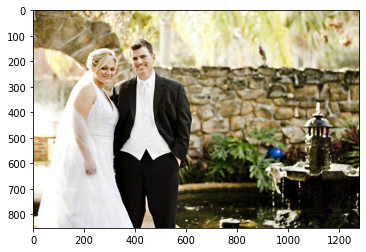

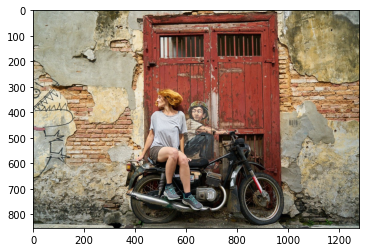

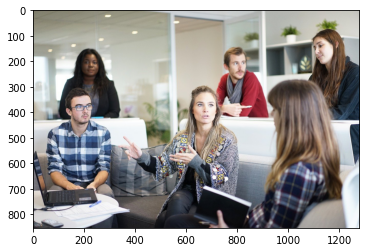

In [21]:
!mkdir outer
!wget https://cdn.pixabay.com/photo/2014/09/23/21/01/newlyweds-458119_1280.jpg -q -O input1.jpg
!wget https://cdn.pixabay.com/photo/2017/12/28/17/10/motorcycles-3045706_1280.jpg -q -O input2.jpg
!wget https://cdn.pixabay.com/photo/2016/03/09/09/22/workplace-1245776_1280.jpg -q -O input3.jpg
shutil.copy("input1.jpg", "outer/input1.jpg")
shutil.copy("input2.jpg", "outer/input2.jpg")
shutil.copy("input3.jpg", "outer/input3.jpg")
!rm input1.jpg
!rm input2.jpg
!rm input3.jpg

im = [Image.open("./outer/input1.jpg").convert("RGB"), Image.open("./outer/input2.jpg").convert("RGB"), Image.open("./outer/input3.jpg").convert("RGB")]
for i in im:
    plt.figure()
    plt.imshow(i)
    plt.show()

Загрузим модель `faster_rcnn` для датасета COCO

In [22]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
model.eval()
frpil = transforms.ToTensor()
pred = model([frpil(i) for i in im])

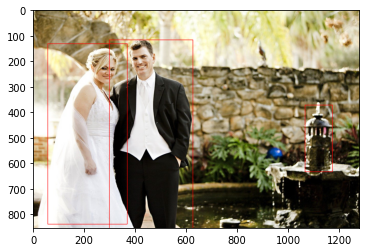

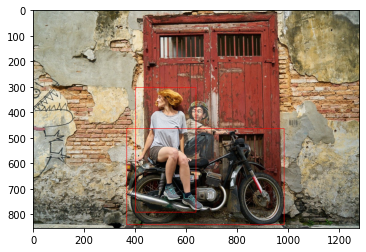

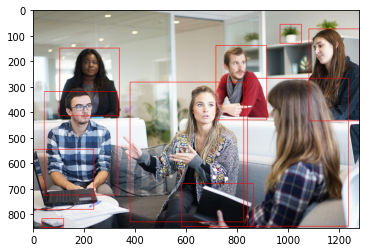

In [23]:
def draw_empty_rect(do, xy):
    do.line((xy[0], xy[1], xy[2], xy[1]), fill='red', width=2)
    do.line((xy[2], xy[1], xy[2], xy[3]), fill='red', width=2)
    do.line((xy[0], xy[3], xy[2], xy[3]), fill='red', width=2)
    do.line((xy[0], xy[1], xy[0], xy[3]), fill='red', width=2)


for i in range(3):
    plt.figure()
    draw = ImageDraw.Draw(im[i])
    for k in range(len(pred[i]['boxes'])):
        if pred[i]['scores'][k] >= 0.9:
            box = pred[i]['boxes'][k]
            draw_empty_rect(draw, box)
    plt.imshow(im[i])

Модель на данных примерах(я не нашёл удобных библиотек для визуализации) выделяла следующие классы: Человек, Книга, Ноутбук, горшок с цветком, Мотоцикл, Фонтан(?), Пульт.

## 3). Выбор датасета

Датасетом я выбрал Wider Face

In [24]:
%%bash
 
download-gdrive 0B6eKvaijfFUDQUUwd21EckhUbWs wider_train.zip
extract-archive wider_train.zip &>/dev/null
download-gdrive 0B6eKvaijfFUDd3dIRmpvSk8tLUk wider_valid.zip
extract-archive wider_valid.zip &>/dev/null

Process is interrupted.


In [ ]:
!wget http://mmlab.ie.cuhk.edu.hk/projects/WIDERFace/support/bbx_annotation/wider_face_split.zip
!unzip wider_face_split.zip > /dev/null
!rm wider_face_split.zip
!rm wider_train.zip
!rm wider_valid.zip

--2021-02-15 07:57:07--  http://mmlab.ie.cuhk.edu.hk/projects/WIDERFace/support/bbx_annotation/wider_face_split.zip
Resolving mmlab.ie.cuhk.edu.hk (mmlab.ie.cuhk.edu.hk)... 137.189.99.12
Connecting to mmlab.ie.cuhk.edu.hk (mmlab.ie.cuhk.edu.hk)|137.189.99.12|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3591642 (3.4M) [application/zip]
Saving to: ‘wider_face_split.zip’

wider_face_split.zi 100%[===================>]   3.42M  2.16MB/s    in 1.6s    

2021-02-15 07:57:09 (2.16 MB/s) - ‘wider_face_split.zip’ saved [3591642/3591642]

replace wider_face_split/readme.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
shutil.copy("./wider_face_split/wider_face_train_bbx_gt.txt", "./WIDER_train/wider_face_train_bbx_gt.txt")
shutil.copy("./wider_face_split/wider_face_val_bbx_gt.txt", "./WIDER_val/wider_face_val_bbx_gt.txt")

## 4). Предобработка данных

Для детекции наш датасет будет возвращать словарь с картинкой, боксами, площадью боксов(для взвешивания), айди картинки, непонятным параметром iscrowd и классами(в нашем случае он один). Стоит заметить что формат входных данных xywh, а формат данных для модели хуху.

In [25]:
def find_area(xy):
    return (float(xy[2]) - float(xy[0])) * (float(xy[3]) - float(xy[1]))


"""
Класс нашего датасета
"""
class WiderFaceDataset(Dataset):
    def __init__(self, txt_file, root_dir, transform=None):
        with open(txt_file) as f:
            lines = f.readlines()
            self.dataset = []
            id = 0
            for ind, line in enumerate(lines):
                if line.rstrip().endswith('.jpg'):
                    self.dataset.append({'file_name': line.rstrip(),
                                         'targets': {'boxes': [],
                                                     'image_id': torch.tensor([id]),
                                                     'labels': [],
                                                     'area': [],
                                                     'iscrowd': []}})
                    id += 1
                elif len(line.split()) != 1:
                    inp = line.split()
                    self.dataset[-1]['targets']['boxes'].append(np.array([float(inp[0]),
                                                                          float(inp[1]),
                                                                          float(inp[0]) + float(inp[2]),
                                                                          float(inp[1]) + float(inp[3])]))
                    self.dataset[-1]['targets']['labels'].append(1)
                    if bool(self.dataset[-1]['targets']['boxes']):
                        self.dataset[-1]['targets']['area'].append(find_area(self.dataset[-1]['targets']['boxes'][-1]))
                    self.dataset[-1]['targets']['iscrowd'].append(False)
        self.dataset = self.dataset[:200]
        self.root_dir = root_dir
        self.transform = transform
 
    def __len__(self):
        return len(self.dataset)
 
    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir,
                                self.dataset[idx]['file_name'])
        image = Image.open(img_name).convert('RGB')
        targets = self.dataset[idx]['targets']
        sample = [image,
                  {'boxes': torch.tensor(targets['boxes']),
                   'image_id': targets['image_id'],
                   'labels': torch.tensor(targets['labels'], device=device).type(torch.int64),
                   'area': torch.tensor(targets['area']),
                   'iscrowd': torch.tensor(targets['iscrowd'])}]

        if self.transform:
            sample = self.transform(sample)
 
        return sample


"""
Класс даталоадера
"""

class MyDataLoader(object):
    def __init__(self, ds, batch_size, shuffle=False):
        self.dataset = ds
        self.batch_size = batch_size
        if shuffle:
            self.perm = np.random.permutation(len(ds))
        else:
            self.perm = np.arange(len(ds))
        self.batch_num = len(ds) // batch_size

    def __iter__(self):
        for i in range(0, len(self.dataset), self.batch_size):
            features = []
            labels = []
            if i + self.batch_size >= len(self.dataset):
                break
            for k in range(i, i + self.batch_size):
                features.append(self.dataset[self.perm[k]][0])
                labels.append({'boxes': self.dataset[self.perm[k]][1]['boxes'],
                               'labels': self.dataset[self.perm[k]][1]['labels'],
                               'image_id': self.dataset[self.perm[k]][1]['image_id'],
                               'area': self.dataset[self.perm[k]][1]['area'],
                               'iscrowd': self.dataset[self.perm[k]][1]['iscrowd']})
            print('iter_passed')
            yield [features, labels]

    def __len__(self):
        return self.batch_num

In [28]:
class MyToTensor(object):
    def __call__(self, sample):
        tf = transforms.ToTensor()
        sample[0] = tf(sample[0])
        return sample


class MyResize(object):
    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size
        self.resize = transforms.Resize(output_size)

    def __call__(self, sample):
        image, targets = sample[0], sample[1]

        h, w = image.shape[1:]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)
        img = self.resize(image)
        boxes = targets['boxes']
        for i in range(len(boxes)):
            boxes[i] = torch.tensor([boxes[i][0] * new_w / w, 
                                     boxes[i][1] * new_h / h,
                                     boxes[i][2] * new_w / w + 1, 
                                     boxes[i][3] * new_h / h + 1])
        targets['boxes'] = boxes

        return [img, targets]

In [29]:
train_set = WiderFaceDataset('WIDER_train/wider_face_train_bbx_gt.txt', 
                             'WIDER_train/images', 
                             transform=transforms.Compose([MyToTensor(),
                                                           MyResize((800, 800))]))
val_set = WiderFaceDataset('WIDER_val/wider_face_val_bbx_gt.txt', 
                           'WIDER_val/images', 
                           transform=transforms.Compose([MyToTensor(),
                                                         MyResize((800, 800))]))

Тут пожалуй и реализуем показ картинок

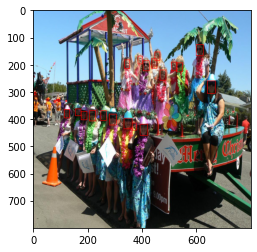

In [30]:
def draw_empty_rect(do, xy):
    do.line((xy[0], xy[1], xy[2], xy[1]), fill='red', width=2)
    do.line((xy[2], xy[1], xy[2], xy[3]), fill='red', width=2)
    do.line((xy[0], xy[3], xy[2], xy[3]), fill='red', width=2)
    do.line((xy[0], xy[1], xy[0], xy[3]), fill='red', width=2)


def show_img(image, targets):
    boxes = targets['boxes']
    tf = transforms.ToPILImage()
    img = tf(deepcopy(image))
    for i in boxes:
        draw = ImageDraw.Draw(img)
        draw_empty_rect(draw, i)
    plt.figure()
    plt.imshow(img)
    plt.show()


sample = train_set[12]
show_img(sample[0], sample[1])

## 5). Обучение модели-детектора

Подсмотрели одну вещь из туториала пайторча и скачали.

In [31]:
!git clone https://github.com/pytorch/vision.git
shutil.copy("./vision/references/detection/engine.py", "./engine.py")
shutil.copy("./vision/references/detection/coco_utils.py", "./coco_utils.py")
shutil.copy("./vision/references/detection/coco_eval.py", "./coco_eval.py")
shutil.copy("./vision/references/detection/utils.py", "./utils.py")
shutil.copy("./vision/references/detection/transforms.py", "./transforms.py")

fatal: destination path 'vision' already exists and is not an empty directory.


'./transforms.py'

Можно скачать веса заранее обученой мной модели.

In [35]:
%%bash
 
download-gdrive 1U1KrmxWxodimcj97G-T4lFV9ovoR-LB7 new_gen_state_dicts.zip
extract-archive new_gen_state_dicts.zip &>/dev/null

--2021-02-15 13:55:00--  https://docs.google.com/uc?export=download&confirm=n_YE&id=1U1KrmxWxodimcj97G-T4lFV9ovoR-LB7
Resolving docs.google.com (docs.google.com)... 108.177.13.113, 108.177.13.138, 108.177.13.102, ...
Connecting to docs.google.com (docs.google.com)|108.177.13.113|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-00-3o-docs.googleusercontent.com/docs/securesc/k919uj7bctob06te1l9rfucpm3euk7nj/fijg1l9t7h96aa4gcahspb2t18aut29i/1613397300000/14651998878917716783/08060829250637482312Z/1U1KrmxWxodimcj97G-T4lFV9ovoR-LB7?e=download [following]
--2021-02-15 13:55:00--  https://doc-00-3o-docs.googleusercontent.com/docs/securesc/k919uj7bctob06te1l9rfucpm3euk7nj/fijg1l9t7h96aa4gcahspb2t18aut29i/1613397300000/14651998878917716783/08060829250637482312Z/1U1KrmxWxodimcj97G-T4lFV9ovoR-LB7?e=download
Resolving doc-00-3o-docs.googleusercontent.com (doc-00-3o-docs.googleusercontent.com)... 173.194.216.132, 2607:f8b0:400c:c12::84
Connectin

In [36]:
!rm new_gen_state_dicts.zip
!rm wider_face_split.zip
!rm wider_train.zip
!rm wider_valid.zip

In [37]:
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
num_classes = 2
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

val_loader = MyDataLoader(val_set, 1)

Код ниже лучше не запускать, это цикл обучения, его я запускал с домашнего ноутбука, так как тут обучалось быстрее, и вывод лоссов на батчах каждой эпохи к сожалению канул в небытьё. Чтобы загрузить веса, запустите ячейку ниже нижнего. Все делал на кпу, ибо на коллабе доступ к гпу закрыли, а дома на гпу не хватало места(так и не понял почему, возможно из-за неиспользования Dataloader объекта). 

In [38]:
from engine import train_one_epoch, evaluate

train_loader = MyDataLoader(train_set, 10, shuffle=True)
num_classes = 2
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)
num_epochs = 10
for epoch in range(5, num_epochs):
    train_one_epoch(model, optimizer, train_loader, device, epoch, print_freq=1)
    torch.save(model.state_dict(), f'older_model{epoch}.pt')
    lr_scheduler.step()
    evaluate(model, val_loader, device=device)
torch.save(model.state_dict(), 'modern_model.pt')
model.eval()

iter_passed


KeyboardInterrupt: ignored

In [42]:
model.load_state_dict(torch.load("new_gen_state_dicts/modern_model.pt"))
model.eval()

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256)
          (relu): ReLU(inplace=True)
          (downsample)

Опять смотрим красивые картинки

[{'boxes': tensor([[ 765.2115,  167.8945,  832.8069,  267.3994],
        [ 191.4425,  169.0008,  256.8291,  258.4678],
        [ 624.7689,  332.1673,  718.8884,  443.3409],
        [1099.8188,  103.9316, 1168.3837,  203.6030],
        [ 151.9610,  342.3032,  228.6878,  445.5720],
        [ 936.9791,  386.2032,  961.3348,  452.6012],
        [ 745.8611,  207.3514,  761.7408,  237.0926],
        [1180.9282,  123.3066, 1193.5751,  138.4979],
        [ 673.1732,  851.5109,  686.3589,  853.0000],
        [ 173.5687,  362.8562,  232.2497,  435.5727]], grad_fn=<StackBackward>), 'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1]), 'scores': tensor([0.9939, 0.9914, 0.9892, 0.9868, 0.9807, 0.0695, 0.0637, 0.0625, 0.0560,
        0.0545], grad_fn=<IndexBackward>)}]


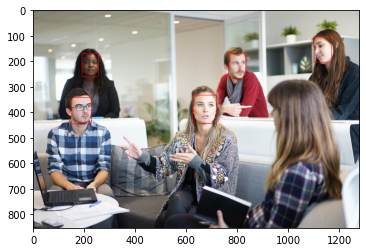

In [43]:
inp = Image.open('outer/input3.jpg') # можете загрузить свою картинку
comp = transforms.Compose([transforms.ToTensor()])
pred = model([comp(inp)])
print(pred)


def draw_empty_rect(do, xy):
    do.line((xy[0], xy[1], xy[2], xy[1]), fill='red', width=2)
    do.line((xy[2], xy[1], xy[2], xy[3]), fill='red', width=2)
    do.line((xy[0], xy[3], xy[2], xy[3]), fill='red', width=2)
    do.line((xy[0], xy[1], xy[0], xy[3]), fill='red', width=2)


plt.figure()
draw = ImageDraw.Draw(inp)
for k in range(len(pred[0]['boxes'])):
    if pred[0]['scores'][k] >= 0.8: # можно изменить тресхолд для бокса
        box = pred[0]['boxes'][k]
        draw_empty_rect(draw, box)
plt.imshow(inp)

## 6). Измерение качества работы модели

## 7). Поиск путей применения этой модели в бизнесе/реальных задачах/набросок встраивания в веб/мобильное демо

Данную модель можно бы было использовать как минимум для выделения лиц людей на фотографиях из соцсетей. Возможно можно было бы обрезать фотографии по боксам, чтобы в дальнейшем обучить какую-нибудь модель для классификации людей на фотографиях по разным признакам, может даже распознание лиц людей.